# Imports and Settings

In [3760]:
from matplotlib import pyplot as plt
import numpy as np
import math

In [3761]:
N_TIME_SAMPLES = 500
N_FREQUENCY_CHANNELS = 128 # Must be power of 2

# Lower bound of the FRB
LOWER_BOUND = np.random.random()*(N_FREQUENCY_CHANNELS-100)

# Upper bound of the FRB
UPPER_BOUND = 100+np.random.random()*(N_FREQUENCY_CHANNELS-LOWER_BOUND-100)

# RFI intensitiy will be in range [0, RFI_STRENGTH)
RFI_STRENGTH = 5

# FRB intensity will be in range [FRB_MIN_STRENGTH, FRB_MAX_STRENGTH)
FRB_MAX_STRENGTH = 10
FRB_MIN_STRENGTH = 5

# Create Data
## Create the data with the background noise

In [3762]:
data = np.random.random( (N_FREQUENCY_CHANNELS, N_TIME_SAMPLES) )*RFI_STRENGTH

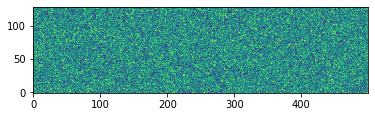

In [3763]:
plt.imshow(data, origin="lower")
plt.show()

## Draw a line in the data

In [3764]:
# Draws a line in the data given the lines slope and y incercept
def draw_line(data, m, b):
    f = lambda x: m*x + b

    # For every x value, fill in y values
    for x in range(N_TIME_SAMPLES):
        draw_back(data, m, b, x, f(x), x+1, f(x+1))
    
    return data

In [3765]:
def draw_back(data, m, b, x0, y0, x1, y1):
    f_inv = lambda y: (y-b)/m

    # Modified Bresenham's line algorithm 
    while y0 <= y1 and f_inv(y1) < N_TIME_SAMPLES:
        err = x1 - f_inv(y0)-0.5
        val = np.random.random()*(FRB_MAX_STRENGTH-FRB_MIN_STRENGTH) + FRB_MIN_STRENGTH

        if err > 0 and y0 < UPPER_BOUND and y0 > LOWER_BOUND:
            data[int(y0)][x0] = val
        elif y0 < UPPER_BOUND and y0 > LOWER_BOUND:
            data[int(y0)][x1] = val
        
        y0 += 1

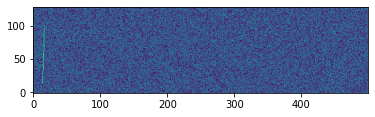

In [3766]:
m = math.tan(np.random.random()*math.pi/4 + math.pi/4) # Choose a ranom slope in range [PI/4, PI/2)
x_intercept = np.random.random()*N_TIME_SAMPLES # Choose a random x intercept in range [0, N_SAMPLES)

b = -m*x_intercept # Calculate the y intercept

data = draw_line(data, m, b) # Draw the line

plt.imshow(data, origin="lower")
plt.show()

# FRB Detection

In [3767]:
def line_detection(data):
    i = 1
    vert_sums = diag_sums = data

    # Version 1
    # while 2**i <= N_FREQUENCY_CHANNELS:
    #     for time_sample in range(N_TIME_SAMPLES):
    #         N = int(N_FREQUENCY_CHANNELS/2**i)
    #         for freq_sample in range(N):
    #             vert = vert_sums[freq_sample*2][time_sample] + vert_sums[freq_sample*2+1][time_sample]

    #             if(time_sample < N_TIME_SAMPLES-1):
    #                 diag = diag_sums[freq_sample*2][time_sample] + diag_sums[freq_sample*2+1][time_sample+1]
                    
    #             vert_sums[freq_sample][time_sample] = vert
    #             diag_sums[freq_sample][time_sample] = diag
        


    # Version 2
    while 2**i <= N_FREQUENCY_CHANNELS:
        N = int(N_FREQUENCY_CHANNELS/2**i)
        for freq_sample in range(N):
            for time_sample in range(N_TIME_SAMPLES):
                vert = vert_sums[freq_sample*2][time_sample] + vert_sums[freq_sample*2+1][time_sample]

                if(time_sample < N_TIME_SAMPLES-1):
                    diag = diag_sums[freq_sample*2][time_sample] + diag_sums[freq_sample*2+1][time_sample+1]
                    
                vert_sums[freq_sample][time_sample] = vert
                diag_sums[freq_sample][time_sample] = diag


        i += 1
        
    
    return vert_sums + diag_sums

In [3768]:
plt.plot(line_detection(data)[0])
plt.show()

# plt.imshow(line_detection(data))
# plt.show()

KeyboardInterrupt: 